
# Deep Learning Homework 6 (Spring 2023)

This code is provided for Deep Learning class (601.482/682) Homework 6. For ease of implementation, we recommend working entire in Google Colaboratory.

@Copyright Cong Gao, the Johns Hopkins University, cgao11@jhu.edu. Modifications made by Hongtao Wu, Suzanna Sia, Hao Ding, Keith Harrigian, and Yiqing Shen.


### Imports

In [8]:
# ## Mount Google Drive Data (If using Google Colaboratory)
# try:
#     from google.colab import drive
#     drive.mount('/content/gdrive')
# except:
#     print("Mounting Failed.")

In [1]:
## Standard Library
import os
import json

## External Libraries
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.transforms import v2
from torch.autograd import Variable
import torch.nn.functional as functional
from torch.utils.data import Dataset, DataLoader
from skimage import io
import matplotlib.pyplot as plt

/Users/gadiraju.s13/anaconda3/envs/DL/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/Users/gadiraju.s13/anaconda3/envs/DL/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please s

# Problem 1: Unsupervised Pre-training

### Training Hyperparameters

These are recommended hyperparameters - please feel free to use what works for you. Batch size can be changed if it does not match your memory, please state your batch step_size in your report.

Dataset is available at: https://livejohnshopkins-my.sharepoint.com/:u:/g/personal/yshen92_jh_edu/EcTxWAXsAhtDiv3vUxCTF8gBgAARCUvvKthb3s-pEExyMg

In [10]:
## Batch Size
train_batch_size = 10
validation_batch_size = 10

## Learning Rate
learning_rate = 0.001

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 200

### Data Paths

In [11]:
# # General Data Directory ##TODO: Please fill in the appropriate directory
# data_dir = "./gdrive/MyDrive/HW6_data"

# ## Segmentation + Colorization Paths
# segmentation_data_dir = f"{data_dir}/segmentation/"
# colorization_data_dir = f"{data_dir}/colorization/"

# # Mask JSON
# mask_json = f"{data_dir}/mapping.json"

# General Data Directory ##TODO: Please fill in the appropriate directory
data_dir = "./HW6_data/"

## Segmentation + Colorization Paths
segmentation_data_dir = f"{data_dir}/segmentation/"
colorization_data_dir = f"{data_dir}/colorization/"

# Mask JSON
mask_json = f"{data_dir}/mapping.json"


### Data Loaders

We have provided you with some preprocessing code for the images but you should feel free to modify the class however you please to support your training schema. In the very least, you will have to modify the dataloader to support loading of the colorization dataset.

In [12]:
## Image Transforms
img_transform = transforms.Compose([
        transforms.ToTensor(),
])

## Image Dataloader
class ImageDataset(Dataset):

    """
    ImageDataset
    """

    def __init__(self,
                 input_dir,
                 op,
                 mask_json_path,
                 transforms=None):
        """
        ##TODO: Add support for colorization dataset

        Args:
            input_dir (str): Path to either colorization or segmentation directory
            op (str): One of "train", "val", or "test" signifying the desired split
            mask_json_path (str): Path to mapping.json file
            transforms (list or None): Image transformations to apply upon loading.
        """
        self.transform = transforms
        self.op = op
        with open(mask_json_path, 'r') as f:
            self.mask = json.load(f)
        self.mask_num = len(self.mask)  # There are 6 categories: grey, dark grey, and black
        self.mask_value = [value for value in self.mask.values()]
        self.mask_value.sort()
        try:
            if self.op == 'train':
                self.data_dir = os.path.join(input_dir, 'train')
            elif self.op == 'val':
                self.data_dir = os.path.join(input_dir, 'validation')
            elif self.op == 'test':
                self.data_dir = os.path.join(input_dir, 'test')
            elif self.op == 'train_color':
                self.data_dir = os.path.join(input_dir, 'train_cor')
            elif self.op == 'val_color':
                self.data_dir = os.path.join(input_dir, 'validation_cor')
        except ValueError:
            print('op should be either train, val or test!')

    def __len__(self):
        """

        """
        return len([d for d in os.listdir(self.data_dir) if os.path.isdir(os.path.join(self.data_dir, d))])

    def __getitem__(self,
                    idx):
        """

        """
        ## Load Image and Parse Properties

        if 'color' in self.op:
          if self.op == 'val_color':
            idx += 1

          img_name = os.path.join(self.data_dir, str(idx), f'{idx}_gray.jpg')
          img = io.imread(img_name)

          if len(img.shape) == 2:
              img = img[:, :, None]
              img = np.repeat(img, 3, axis=2)

          # Create a mask
          mask_name = os.path.join(self.data_dir, str(idx), f'{idx}_input.jpg')
          mask = io.imread(mask_name)

          # Add Transforms
          if self.transform:
            img, mask = self.img_transform(img, mask)
          return img, mask

        img_name = str(idx) + '_input.jpg'
        mask_name = str(idx) + '_mask.png'
        img = io.imread(os.path.join(self.data_dir, str(idx), img_name))
        mask = io.imread(os.path.join(self.data_dir, str(idx), mask_name))
        if len(mask.shape) == 2:
            h, w  = mask.shape
        elif len(mask.shape) == 3:
            h, w, c = mask.shape
        ## Convert grey-scale label to one-hot encoding
        new_mask = np.zeros((h, w, self.mask_num))
        for idx in range(self.mask_num):
            #if the mask has 3 dimension use this code
            new_mask[:, :, idx] = mask[:,:,0] == self.mask_value[idx]
            #if the mask has 1 dimension use the code below
            #new_mask[:, :, idx] = mask == self.mask_value[idx]
        ## Transform image and mask
        if self.transform:
            img, mask = self.img_transform(img, new_mask)
        # ## Use dictionary to output
        # sample = {'img': img, 'mask': mask}
        # return sample
        return img, mask

    def img_transform(self,
                      img,
                      mask):
        """

        """
        ## Apply Transformations to Image and Mask
        img = self.transform(img)
        mask = self.transform(mask)
        return img, mask

## Model Architecture

Finish building the U-net architecture below.

In [13]:
## Functions for adding the convolution layer
def add_conv_stage(dim_in,
                   dim_out,
                   kernel_size=3,
                   stride=1,
                   padding=1,
                   bias=True,
                   useBN=True):
    """

    """
    # Use batch normalization
    if useBN:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1)
        )
    # No batch normalization
    else:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU(),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU()
        )

## Upsampling
def upsample(ch_coarse,
             ch_fine):
    """

    """
    return nn.Sequential(
                    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
                    nn.ReLU())


# U-Net
class UNET(nn.Module):

    """

    """
    def __init__(self, n_classes, useBN=True):
        """
        Args:
            n_classes (int): Number of classes
            useBN (bool): Turn Batch Norm on or off. (Hint: Using BatchNorm might help you achieve better performance.)
        """
        super(UNET, self).__init__()
        # Downgrade stages
        self.conv1 = add_conv_stage(3, 32, useBN=useBN)
        self.conv2 = add_conv_stage(32, 64, useBN=useBN)
        self.conv3 = add_conv_stage(64, 128, useBN=useBN)
        self.conv4 = add_conv_stage(128, 256, useBN=useBN)
        # Upgrade stages
        self.conv3m = add_conv_stage(256, 128, useBN=useBN)
        self.conv2m = add_conv_stage(128,  64, useBN=useBN)
        self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
        # Maxpool
        self.max_pool = nn.MaxPool2d(2)
        # Upsample layers
        self.upsample43 = upsample(256, 128)
        self.upsample32 = upsample(128,  64)
        self.upsample21 = upsample(64 ,  32)
        # weight initialization
        # You can have your own weight intialization. This is just an example.
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()
        #TODO: Design your last layer & activations
        self.finalLayer = nn.Conv2d(32, n_classes, kernel_size=1)
        self.finalActivation = nn.Softmax(dim=1)

    def forward(self, x):
        """
        Forward pass
        """
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(self.max_pool(conv1_out))
        conv3_out = self.conv3(self.max_pool(conv2_out))
        conv4_out = self.conv4(self.max_pool(conv3_out))

        conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
        conv3m_out  = self.conv3m(conv4m_out_)

        conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
        conv2m_out  = self.conv2m(conv3m_out_)

        conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
        conv1m_out  = self.conv1m(conv2m_out_)

        #TODO: Design your last layer & activations
        final_out = self.finalLayer(conv1m_out)
        final_act = self.finalActivation(final_out)
        return final_act


### DICE Score and DICE Loss

Finish implementing the DICE score function below and then write a Dice Loss function that you can use to update your model weights.

In [14]:
##TODO: Finish implementing the multi-class DICE score function
def dice_score_image(prediction, target, n_classes):
    '''
      computer the mean dice score for a single image

      Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does
      Args:
          prediction (tensor): predictied labels of the image
          target (tensor): ground truth of the image
          n_classes (int): number of classes

      Returns:
          m_dice (float): Mean dice score over classes
    '''
    ## Should test image one by one
    assert prediction.shape[0] == 1 #This line can not be deleted
    ## TODO: Compute Dice Score for Each Class. Compute Mean Dice Score over Classes.
    target = torch.argmax(target, dim=1)
    dice_classes = np.zeros(n_classes)
    for cl in range(n_classes):
        TP = ((prediction == cl) & (target == cl)).sum().item()
        FP = ((prediction == cl) & (target != cl)).sum().item()
        FN = ((prediction != cl) & (target == cl)).sum().item()
        #When there is no ground truth of the class in this image
        if TP == 0 and (FP + FN) == 0:
        #Give 1 dice score if False Positive pixel number is 0,
          if FP == 0:
            score = 1.0
        #give 0 dice score if False Positive pixel number is not 0 (> 0).
          elif FP > 0:
            score = 0.0
        else:
          smooth = 1e-10 # Avoid division by zero
          score = (2 * TP + smooth) / (2*TP + FP+ FN + smooth)

        dice_classes[cl] = score
    return dice_classes.mean()



def dice_score_dataset(model, dataloader, num_classes, use_gpu=False):
    """
    Compute the mean dice score on a set of data.

    Note that multiclass dice score can be defined as the mean over classes of binary
    dice score. Dice score is computed per image. Mean dice score over the dataset is the dice
    score averaged across all images.

    Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does

    Args:
        model (UNET class): Your trained model
        dataloader (DataLoader): Dataset for evaluation
        num_classes (int): Number of classes

    Returns:
        m_dice (float): Mean dice score over the input dataset
    """
    ## Number of Batches and Cache over Dataset
    n_batches = len(dataloader)
    scores = np.zeros(n_batches)
    ## Evaluate
    model.eval()
    idx = 0
    for data in dataloader:
        ## Format Data
        img, target = data
        if use_gpu:
            img = img.cuda()
            target = target.cuda()
        ## Make Predictions
        out = model(img)
        n_classes = out.shape[1]
        prediction = torch.argmax(out, dim = 1)
        scores[idx] = dice_score_image(prediction, target, n_classes)
        idx += 1
    ## Average Dice Score Over Images
    m_dice = scores.mean()
    return m_dice


## TODO: Implement DICE loss,
#  It should conform to to how we computer the dice score.
class DICELoss(nn.Module):
    def __init__(self, n_classes):
      super(DICELoss,self).__init__()
      self.n_classes = n_classes

    def forward(self, prediction, target):
      smooth = 1e-10
      intersect = (prediction * target).sum()
      score = (2*intersect + smooth)/(prediction.sum()+target.sum()+smooth)
      return 1 - score

## Training Procedure (Segmentation)

In [15]:
## Initialize your unet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

n_classes = 6
model = UNET(n_classes)
model = model.to(device)

loss_fn = DICELoss(n_classes).to(device)

## Initialize Dataloaders
train_dataset=ImageDataset(input_dir=segmentation_data_dir, op="train", mask_json_path=mask_json, transforms=img_transform)
validation_dataset=ImageDataset(input_dir=segmentation_data_dir, op="val", mask_json_path=mask_json, transforms=img_transform)
test_dataset=ImageDataset(input_dir=segmentation_data_dir, op="test", mask_json_path=mask_json, transforms=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=validation_batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


# Loss Lists
train_losses = []
val_losses = []
test_losses = []

# Dice Scores
train_dice_scores = []
val_dice_scores = []
test_dice_scores = []
best_val_loss = np.inf # Track lowest validation loss for early stopping
threshold = 0.0005 # Threshold for loss improvement
patience = 5 # Epochs to wait for early stopping
count_epoch = 0 # Track number of epochs without improvement

print("Start Training...")
for epoch in range(num_epochs):
    ########################### Training #####################################
    # TODO: Design your own training section
    model.train()
    train_loss = 0.0

    for batch_num, (images, masks) in enumerate(train_dataloader):
      images, masks = images.to(device), masks.to(device)
      optimizer.zero_grad()
      prediction = model(images)

      loss = loss_fn(prediction, masks)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()

    train_losses.append(train_loss/len(train_dataloader))

    ########################### Validation #####################################
    # TODO: Design your own validation section
    model.eval()
    val_loss = 0.0
    val_dice = 0.0

    with torch.no_grad():
      for batch_num, (images, masks) in enumerate(validation_dataloader):
        images, masks = images.to(device), masks.to(device)

        prediction = model(images)
        loss = loss_fn(prediction, masks)
        val_loss += loss.item()

      val_losses.append(val_loss/len(validation_dataloader))
      print(f'Epoch: {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}')

  ############################# Early Stopping #################################
    if val_losses[-1] < best_val_loss - threshold:
      best_val_loss = val_losses[-1]
      count_epoch = 0
    else:
      count_epoch += 1

    if count_epoch == patience:
      print("Early Stopping Activated")
      break

    scheduler.step()


print("Finished Training")
print("Starting Testing...")

################# Testing ##################################
model.eval()
test_loss = 0.0
test_dice = 0.0

with torch.no_grad():
  for batch_num, (images, masks) in enumerate(test_dataloader):
    images, masks = images.to(device), masks.to(device)

    prediction = model(images)
    loss = loss_fn(prediction, masks)
    test_loss += loss.item()

test_losses.append(test_loss/len(test_dataloader))
test_dice = dice_score_dataset(model, test_dataloader, n_classes, use_gpu=True)
print(f'Test Loss: {test_losses[-1]}')
print(f'Test Set Dice Score: {test_dice}')

Device:  cuda
Start Training...
Epoch: 1/200 | Train Loss: 0.6144 | Val Loss: 0.4870
Epoch: 2/200 | Train Loss: 0.4279 | Val Loss: 0.3191
Epoch: 3/200 | Train Loss: 0.3023 | Val Loss: 0.2666
Epoch: 4/200 | Train Loss: 0.2124 | Val Loss: 0.2904
Epoch: 5/200 | Train Loss: 0.1604 | Val Loss: 0.1761
Epoch: 6/200 | Train Loss: 0.1304 | Val Loss: 0.1347
Epoch: 7/200 | Train Loss: 0.1173 | Val Loss: 0.1392
Epoch: 8/200 | Train Loss: 0.1098 | Val Loss: 0.1547
Epoch: 9/200 | Train Loss: 0.1035 | Val Loss: 0.1196
Epoch: 10/200 | Train Loss: 0.0986 | Val Loss: 0.1189
Epoch: 11/200 | Train Loss: 0.0951 | Val Loss: 0.0948
Epoch: 12/200 | Train Loss: 0.0913 | Val Loss: 0.0935
Epoch: 13/200 | Train Loss: 0.0896 | Val Loss: 0.0936
Epoch: 14/200 | Train Loss: 0.0889 | Val Loss: 0.0921
Epoch: 15/200 | Train Loss: 0.0884 | Val Loss: 0.0917
Epoch: 16/200 | Train Loss: 0.0892 | Val Loss: 0.0918
Epoch: 17/200 | Train Loss: 0.0879 | Val Loss: 0.0933
Epoch: 18/200 | Train Loss: 0.0877 | Val Loss: 0.0938
Epoch

# Plotting for 1a


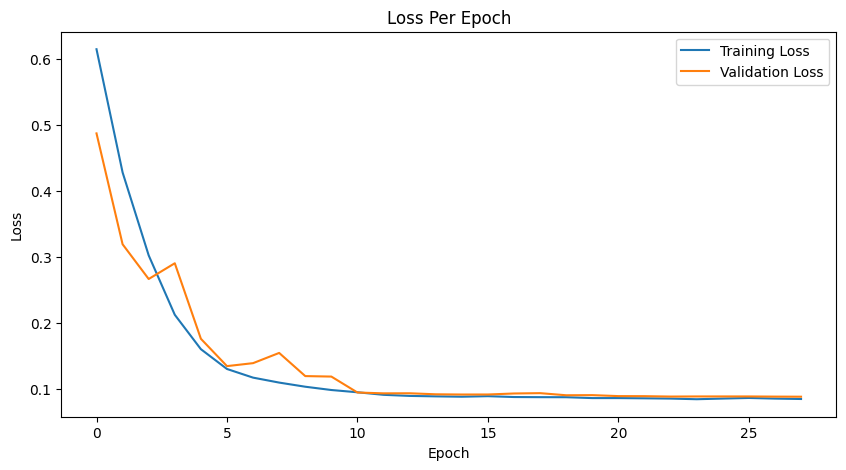

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Per Epoch')
plt.legend()
plt.show()

# 1b - Data Augmentation


In [17]:
## Image Transforms

## Data Augmentation with Horizontal and Vertical Flips
img_transform = transforms.v2.Compose([
      transforms.v2.RandomHorizontalFlip(p=0.6),
      transforms.v2.RandomVerticalFlip(p=0.6),
      transforms.v2.ToTensor()
])

## Initialize your unet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

n_classes = 6
model = UNET(n_classes)
model = model.to(device)

loss_fn = DICELoss(n_classes).to(device)

## Initialize Dataloaders
train_dataset=ImageDataset(input_dir=segmentation_data_dir, op="train", mask_json_path=mask_json, transforms=img_transform)
validation_dataset=ImageDataset(input_dir=segmentation_data_dir, op="val", mask_json_path=mask_json, transforms=img_transform)
test_dataset=ImageDataset(input_dir=segmentation_data_dir, op="test", mask_json_path=mask_json, transforms=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=validation_batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


# Loss Lists
train_losses = []
val_losses = []
test_losses = []

# Dice Scores
train_dice_scores = []
val_dice_scores = []
test_dice_scores = []
best_val_loss = np.inf # Track lowest validation loss for early stopping
threshold = 0.0005 # Threshold for loss improvement
patience = 5 # Epochs to wait for early stopping
count_epoch = 0 # Track number of epochs without improvement

print("Start Training...")
for epoch in range(num_epochs):
    ########################### Training #####################################
    # TODO: Design your own training section
    model.train()
    train_loss = 0.0

    for batch_num, (images, masks) in enumerate(train_dataloader):
      images, masks = images.to(device), masks.to(device)
      optimizer.zero_grad()
      prediction = model(images)

      loss = loss_fn(prediction, masks)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()

    train_losses.append(train_loss/len(train_dataloader))

    ########################### Validation #####################################
    # TODO: Design your own validation section
    model.eval()
    val_loss = 0.0
    val_dice = 0.0

    with torch.no_grad():
      for batch_num, (images, masks) in enumerate(validation_dataloader):
        images, masks = images.to(device), masks.to(device)

        prediction = model(images)
        loss = loss_fn(prediction, masks)
        val_loss += loss.item()

      val_losses.append(val_loss/len(validation_dataloader))
      print(f'Epoch: {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}')

  ############################# Early Stopping #################################
    if val_losses[-1] < best_val_loss - threshold:
      best_val_loss = val_losses[-1]
      count_epoch = 0
    else:
      count_epoch += 1

    if count_epoch == patience:
      print("Early Stopping Activated")
      break

    scheduler.step()


print("Finished Training")
print("Starting Testing...")

################# Testing ##################################
model.eval()
test_loss = 0.0
test_dice = 0.0

with torch.no_grad():
  for batch_num, (images, masks) in enumerate(test_dataloader):
    images, masks = images.to(device), masks.to(device)

    prediction = model(images)
    loss = loss_fn(prediction, masks)
    test_loss += loss.item()

test_losses.append(test_loss/len(test_dataloader))
test_dice = dice_score_dataset(model, test_dataloader, n_classes, use_gpu=True)
print(f'Test Loss: {test_losses[-1]}')
print(f'Test Set Dice Score: {test_dice}')


C:\Users\priya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Device:  cuda
Start Training...
Epoch: 1/200 | Train Loss: 0.6723 | Val Loss: 0.4986
Epoch: 2/200 | Train Loss: 0.4898 | Val Loss: 0.3760
Epoch: 3/200 | Train Loss: 0.3424 | Val Loss: 0.3128
Epoch: 4/200 | Train Loss: 0.2275 | Val Loss: 0.2132
Epoch: 5/200 | Train Loss: 0.1647 | Val Loss: 0.1510
Epoch: 6/200 | Train Loss: 0.1319 | Val Loss: 0.1306
Epoch: 7/200 | Train Loss: 0.1183 | Val Loss: 0.1393
Epoch: 8/200 | Train Loss: 0.1061 | Val Loss: 0.1116
Epoch: 9/200 | Train Loss: 0.0991 | Val Loss: 0.1013
Epoch: 10/200 | Train Loss: 0.0950 | Val Loss: 0.0952
Epoch: 11/200 | Train Loss: 0.0907 | Val Loss: 0.0923
Epoch: 12/200 | Train Loss: 0.0896 | Val Loss: 0.0922
Epoch: 13/200 | Train Loss: 0.0881 | Val Loss: 0.0908
Epoch: 14/200 | Train Loss: 0.0874 | Val Loss: 0.0904
Epoch: 15/200 | Train Loss: 0.0875 | Val Loss: 0.0890
Epoch: 16/200 | Train Loss: 0.0863 | Val Loss: 0.0881
Epoch: 17/200 | Train Loss: 0.0856 | Val Loss: 0.0883
Epoch: 18/200 | Train Loss: 0.0860 | Val Loss: 0.0872
Epoch

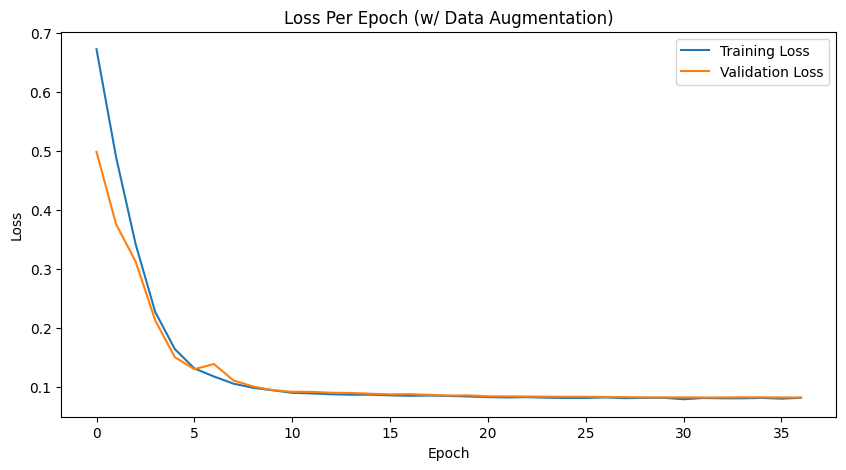

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Per Epoch (w/ Data Augmentation)')
plt.legend()
plt.show()

## Training Procedure: Colorization Pre-training

Complete the rest of this problem in the cells below.

Device:  cuda
Start Training...
Epoch: 1/200 | Train Loss: 0.0032 | Val Loss: 0.0021
Epoch: 2/200 | Train Loss: 0.0012 | Val Loss: 0.0020
Epoch: 3/200 | Train Loss: 0.0010 | Val Loss: 0.0018
Epoch: 4/200 | Train Loss: 0.0009 | Val Loss: 0.0017
Epoch: 5/200 | Train Loss: 0.0008 | Val Loss: 0.0015
Epoch: 6/200 | Train Loss: 0.0008 | Val Loss: 0.0014
Epoch: 7/200 | Train Loss: 0.0007 | Val Loss: 0.0021
Epoch: 8/200 | Train Loss: 0.0007 | Val Loss: 0.0012
Epoch: 9/200 | Train Loss: 0.0006 | Val Loss: 0.0016
Epoch: 10/200 | Train Loss: 0.0006 | Val Loss: 0.0015
Epoch: 11/200 | Train Loss: 0.0005 | Val Loss: 0.0011
Epoch: 12/200 | Train Loss: 0.0005 | Val Loss: 0.0011
Epoch: 13/200 | Train Loss: 0.0005 | Val Loss: 0.0011
Epoch: 14/200 | Train Loss: 0.0005 | Val Loss: 0.0011
Epoch: 15/200 | Train Loss: 0.0004 | Val Loss: 0.0011
Epoch: 16/200 | Train Loss: 0.0004 | Val Loss: 0.0012
Epoch: 17/200 | Train Loss: 0.0005 | Val Loss: 0.0010
Epoch: 18/200 | Train Loss: 0.0004 | Val Loss: 0.0009
Epoch

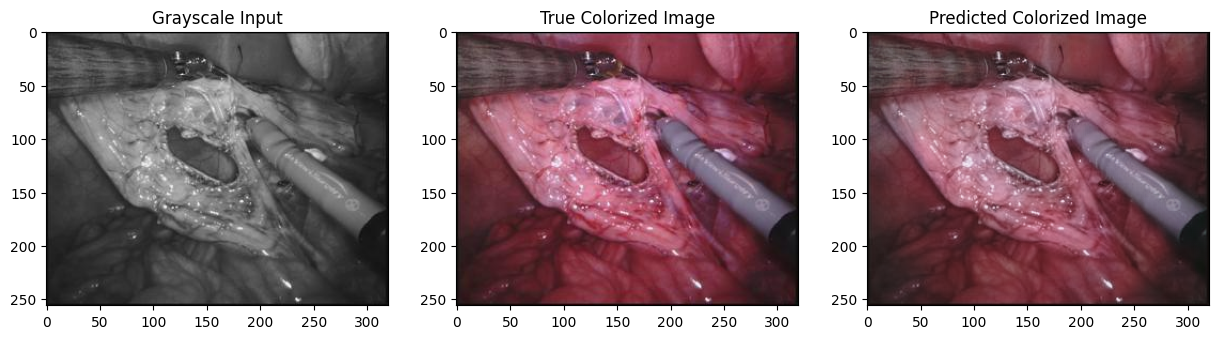

Finished Training


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

n_classes = 3
model = UNET(n_classes)
model.finalActivation = nn.Sigmoid()
model = model.to(device)

loss_fn = nn.MSELoss() # Use Mean Squared Error for loss
img_transform = transforms.Compose([
        transforms.ToTensor(),
])

## Initialize Dataloaders w/ Colorization Data
train_dataset=ImageDataset(input_dir=colorization_data_dir, op="train_color", mask_json_path=mask_json, transforms=img_transform)
validation_dataset=ImageDataset(input_dir=colorization_data_dir, op="val_color", mask_json_path=mask_json, transforms=img_transform)

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=validation_batch_size, shuffle=False)

## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


# Loss Lists
train_losses = []
val_losses = []
test_losses = []

# Dice Scores
train_dice_scores = []
val_dice_scores = []
test_dice_scores = []
best_val_loss = np.inf # Track lowest validation loss for early stopping
threshold = 0.0005 # Threshold for loss improvement
patience = 20 # Epochs to wait for early stopping
count_epoch = 0 # Track number of epochs without improvement

print("Start Training...")
for epoch in range(num_epochs):
    ########################### Training #####################################
    # TODO: Design your own training section
    model.train()
    train_loss = 0.0

    for batch_num, (images, masks) in enumerate(train_dataloader):
      images, masks = images.to(device), masks.to(device)
      optimizer.zero_grad()
      prediction = model(images)

      loss = loss_fn(prediction, masks)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()

    train_losses.append(train_loss/len(train_dataloader))

    ########################### Validation #####################################
    # TODO: Design your own validation section
    model.eval()
    val_loss = 0.0
    val_dice = 0.0

    with torch.no_grad():
      for batch_num, (images, masks) in enumerate(validation_dataloader):
        images, masks = images.to(device), masks.to(device)

        prediction = model(images)
        loss = loss_fn(prediction, masks)
        val_loss += loss.item()

      val_losses.append(val_loss/len(validation_dataloader))
      print(f'Epoch: {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}')

  ############################# Early Stopping #################################
    if val_losses[-1] < best_val_loss - threshold:
      best_val_loss = val_losses[-1]
      count_epoch = 0
    else:
      count_epoch += 1

    if count_epoch == patience:
      print("Early Stopping Activated")
      plt.figure(figsize=(15,5))

      # Display Input
      plt.subplot(1, 3, 1)
      plt.imshow(images[0].permute(1, 2, 0).cpu().numpy(), cmap='gray')
      plt.title('Grayscale Input')

      # Display True Image
      plt.subplot(1, 3, 2)
      plt.imshow(masks[0].permute(1, 2, 0).cpu().numpy())
      plt.title('True Colorized Image')

      # Display Predicted Colorization
      plt.subplot(1, 3, 3)
      plt.imshow(prediction[0].permute(1, 2, 0).cpu().detach().numpy())
      plt.title('Predicted Colorized Image')

      plt.show()
      break

    scheduler.step()


print("Finished Training")

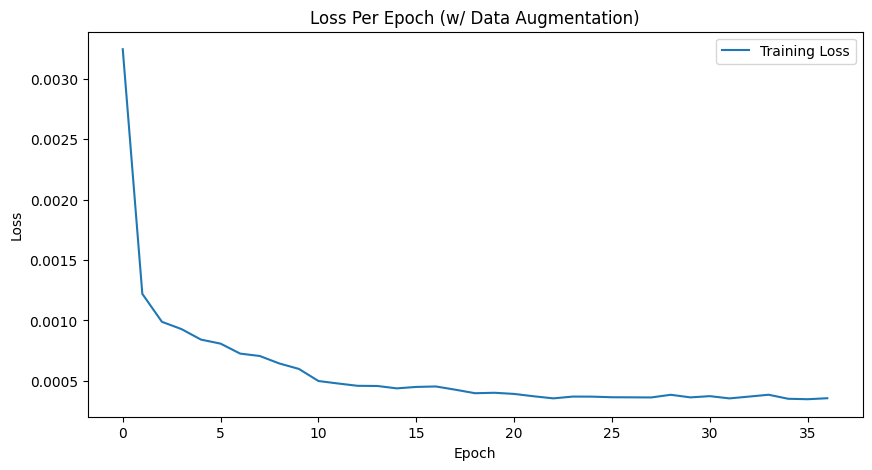

In [20]:
 # Save Model Produced from 1-C for initialization
model_save_path = os.path.join(os.getcwd(), '1c_model.pth')
torch.save(model.state_dict(), model_save_path)

# Print Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Per Epoch (w/ Data Augmentation)')
plt.legend()
plt.show()

# 1D

In [21]:
# Load colorized pre-trained model
pretrained_dict = torch.load('1c_model.pth')


## Data Augmentation with Horizontal and Vertical Flips
img_transform = transforms.v2.Compose([
      transforms.v2.RandomHorizontalFlip(p=0.6),
      transforms.v2.RandomVerticalFlip(p=0.6),
      transforms.v2.ToTensor()
])

## Initialize UNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

n_classes = 6
model = UNET(n_classes)
model = model.to(device)

# Load pretrained data into model
model_dict = model.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and model_dict[k].size() == v.size()}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict, strict=False)

if 'finalLayer.weight' in model_dict:
    nn.init.xavier_uniform_(model.finalLayer.weight)
if 'finalLayer.bias' in model_dict:
    nn.init.zeros_(model.finalLayer.bias)

model.finalActivation = nn.Sigmoid()
loss_fn = DICELoss(n_classes).to(device)

## Initialize Dataloaders
train_dataset=ImageDataset(input_dir=segmentation_data_dir, op="train", mask_json_path=mask_json, transforms=img_transform)
validation_dataset=ImageDataset(input_dir=segmentation_data_dir, op="val", mask_json_path=mask_json, transforms=img_transform)
test_dataset=ImageDataset(input_dir=segmentation_data_dir, op="test", mask_json_path=mask_json, transforms=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=validation_batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


# Loss Lists
train_losses = []
val_losses = []
test_losses = []

# Dice Scores
train_dice_scores = []
val_dice_scores = []
test_dice_scores = []
best_val_loss = np.inf # Track lowest validation loss for early stopping
threshold = 0.0005 # Threshold for loss improvement
patience = 10 # Epochs to wait for early stopping
count_epoch = 0 # Track number of epochs without improvement

print("Start Training...")
for epoch in range(num_epochs):
    ########################### Training #####################################
    # TODO: Design your own training section
    model.train()
    train_loss = 0.0

    for batch_num, (images, masks) in enumerate(train_dataloader):
      images, masks = images.to(device), masks.to(device)
      optimizer.zero_grad()
      prediction = model(images)

      loss = loss_fn(prediction, masks)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()

    train_losses.append(train_loss/len(train_dataloader))

    ########################### Validation #####################################
    # TODO: Design your own validation section
    model.eval()
    val_loss = 0.0
    val_dice = 0.0

    with torch.no_grad():
      for batch_num, (images, masks) in enumerate(validation_dataloader):
        images, masks = images.to(device), masks.to(device)

        prediction = model(images)
        loss = loss_fn(prediction, masks)
        val_loss += loss.item()

      val_losses.append(val_loss/len(validation_dataloader))
      print(f'Epoch: {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}')

  ############################# Early Stopping #################################
    if val_losses[-1] < best_val_loss - threshold:
      best_val_loss = val_losses[-1]
      count_epoch = 0
    else:
      count_epoch += 1

    if count_epoch == patience:
      print("Early Stopping Activated")
      break

    scheduler.step()


print("Finished Training")
print("Starting Testing...")

################# Testing ##################################
model.eval()
test_loss = 0.0
test_dice = 0.0

with torch.no_grad():
  for batch_num, (images, masks) in enumerate(test_dataloader):
    images, masks = images.to(device), masks.to(device)

    prediction = model(images)
    loss = loss_fn(prediction, masks)
    test_loss += loss.item()

test_losses.append(test_loss/len(test_dataloader))
test_dice = dice_score_dataset(model, test_dataloader, n_classes, use_gpu=True)
print(f'Test Loss: {test_losses[-1]}')
print(f'Test Set Dice Score: {test_dice}')

Device:  cuda
Start Training...
Epoch: 1/200 | Train Loss: 0.5972 | Val Loss: 0.5899
Epoch: 2/200 | Train Loss: 0.4969 | Val Loss: 0.4561
Epoch: 3/200 | Train Loss: 0.4014 | Val Loss: 0.3309
Epoch: 4/200 | Train Loss: 0.3002 | Val Loss: 0.2663
Epoch: 5/200 | Train Loss: 0.2201 | Val Loss: 0.1781
Epoch: 6/200 | Train Loss: 0.1606 | Val Loss: 0.1374
Epoch: 7/200 | Train Loss: 0.1279 | Val Loss: 0.1299
Epoch: 8/200 | Train Loss: 0.1078 | Val Loss: 0.1154
Epoch: 9/200 | Train Loss: 0.0959 | Val Loss: 0.0954
Epoch: 10/200 | Train Loss: 0.0875 | Val Loss: 0.1040
Epoch: 11/200 | Train Loss: 0.0810 | Val Loss: 0.0826
Epoch: 12/200 | Train Loss: 0.0768 | Val Loss: 0.0797
Epoch: 13/200 | Train Loss: 0.0758 | Val Loss: 0.0788
Epoch: 14/200 | Train Loss: 0.0731 | Val Loss: 0.0782
Epoch: 15/200 | Train Loss: 0.0739 | Val Loss: 0.0772
Epoch: 16/200 | Train Loss: 0.0721 | Val Loss: 0.0757
Epoch: 17/200 | Train Loss: 0.0716 | Val Loss: 0.0756
Epoch: 18/200 | Train Loss: 0.0703 | Val Loss: 0.0742
Epoch

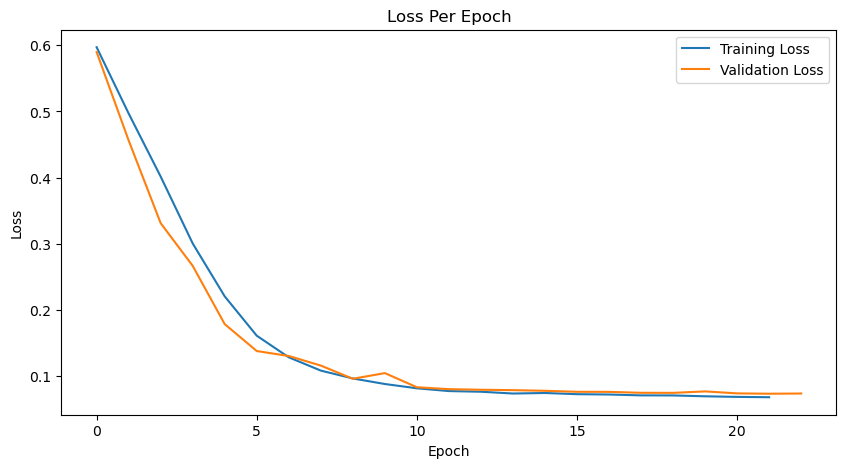

In [3]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Per Epoch')
plt.legend()
plt.show()

# Problem 2: Transfer Learning

### Imports

In [38]:
## Import VGG and FashionMNIST
from torchvision.models import vgg16
from torchvision.datasets import FashionMNIST

### Data Loading

In [39]:
## Specify Batch Size
train_batch_size = 32
test_batch_size = 32

## Specify Image Transforms
img_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

## Download Datasets
train_data = FashionMNIST('./data', transform=img_transform, download=True, train=True)
test_data = FashionMNIST('./data', transform=img_transform, download=True, train=False)

## Initialize Dataloaders
training_dataloader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=test_batch_size, shuffle=True)

### Model Initialization and Training/Fine-tuning

Complete the rest of the assignment in the notebook below.

In [40]:
## Initialize VGG
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

n_classes = 10
model = vgg16(num_classes=n_classes, pretrained=False)

loss_fn = nn.CrossEntropyLoss()

## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

## Initialize Weights
# def set_weights(model):
#     if isinstance(model, nn.Conv2d) or isinstance(model, nn.Linear):
#         nn.init.xavier_uniform_(model.weight.data)
def weights_init(model):
    if isinstance(model, nn.Conv2d) or isinstance(model, nn.Linear):
        nn.init.kaiming_uniform_(model.weight.data)

model.apply(weights_init)
model = model.to(device)

# Loss Lists
train_losses = []
test_losses = []

# Accuracy Scores
train_scores = []
test_scores = []

best_train_loss = np.inf # Track lowest training loss for early stopping
threshold = 0.005 # Threshold for loss improvement
patience = 10 # Epochs to wait for early stopping
count_epoch = 0 # Track number of epochs without improvement
num_epochs = 20
def calc_accuracy(prediction, target):
  _, predicted = torch.max(prediction, 1)
  correct = (predicted == target).sum().item() # Compare predicted labels to true labels
  accuracy = (correct / target.size(0)) * 100.0
  return accuracy

print("Start Training...")
for epoch in range(num_epochs):
    ########################### Training #####################################
    # TODO: Design your own training section
    model.train()
    train_loss = 0.0
    batch_accuracies = []

    total_correct = 0
    total_samples = 0
    for images, target in training_dataloader:
      images, target = images.to(device), target.to(device)
      if images.shape[1] == 1:
        images = images.repeat(1,3,1,1)

      optimizer.zero_grad()
      prediction = model(images)

      loss = loss_fn(prediction, target)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      # batch_accuracy = calc_accuracy(prediction,target)
      # batch_accuracies.append(batch_accuracy)

      _, pred = torch.max(prediction,1)
      total_correct += (pred == target).sum().item()
      total_samples += target.size(0)
      acc = (total_correct/total_samples)*100
      batch_accuracies.append(acc)
    # train_losses.append(train_loss/len(training_dataloader))
    # print(len(batch_accuracies))
    # avg_train_accuracy = torch.mean(torch.Tensor(batch_accuracies))
    # train_scores.append(avg_train_accuracy)

    train_losses.append(train_loss / len(training_dataloader))
    train_accuracy = torch.mean(torch.Tensor(batch_accuracies)).to(device)
    train_scores.append(train_accuracy)

    print(f'Epoch: {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Training Accuracy: {train_scores[-1]:.4f}')
  ############################# Early Stopping #################################
    if train_losses[-1] < best_train_loss - threshold:
      best_train_loss = train_losses[-1]
      count_epoch = 0
    else:
      count_epoch += 1

    if count_epoch == patience:
      print("Early Stopping Activated")
      break

    scheduler.step()


print("Finished Training")
print("Starting Testing...")

################# Testing ##################################
model.eval()
test_loss = 0.0
total_correct = 0
total_samples = 0

with torch.no_grad():
    batch_accuracies = []

    for images, target in test_dataloader:
      images, target = images.to(device), target.to(device)
      if images.shape[1] == 1:
        images = images.repeat(1,3,1,1)

      prediction = model(images)

      loss = loss_fn(prediction, target)

      test_loss += loss.item()
      # batch_accuracy = calc_accuracy(prediction,target)
      # batch_accuracies.append(batch_accuracy)

      _, pred = torch.max(prediction,1)
      total_correct += (pred == target).sum().item()
      total_samples += target.size(0)
      acc = (total_correct/total_samples)*100
      batch_accuracies.append(acc)

# test_losses.append(test_losses / len(test_dataloader))
# test_score = torch.mean(torch.Tensor(batch_accuracies))
test_losses.append(test_loss / len(test_dataloader))
test_accuracy = torch.mean(torch.Tensor(batch_accuracies)).to(device)
test_scores.append(test_accuracy)
print(f'Test Loss: {test_losses[-1]}')
print(f'Test Accuracy: {test_scores[-1]}')

Device:  cuda


C:\Users\priya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\priya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Start Training...
Epoch: 1/20 | Train Loss: 0.9635 | Training Accuracy: 70.0778
Epoch: 2/20 | Train Loss: 0.3435 | Training Accuracy: 87.6032
Epoch: 3/20 | Train Loss: 0.3045 | Training Accuracy: 88.7420
Epoch: 4/20 | Train Loss: 0.2926 | Training Accuracy: 89.7169
Epoch: 5/20 | Train Loss: 0.2718 | Training Accuracy: 89.4564
Epoch: 6/20 | Train Loss: 0.2742 | Training Accuracy: 90.1904
Epoch: 7/20 | Train Loss: 0.2482 | Training Accuracy: 91.1551
Epoch: 8/20 | Train Loss: 0.2424 | Training Accuracy: 91.7809
Epoch: 9/20 | Train Loss: 0.2903 | Training Accuracy: 90.4969
Epoch: 10/20 | Train Loss: 0.2283 | Training Accuracy: 91.5040
Epoch: 11/20 | Train Loss: 0.1708 | Training Accuracy: 92.8542
Epoch: 12/20 | Train Loss: 0.1380 | Training Accuracy: 95.0568
Epoch: 13/20 | Train Loss: 0.1237 | Training Accuracy: 95.0875
Epoch: 14/20 | Train Loss: 0.1112 | Training Accuracy: 95.7999
Epoch: 15/20 | Train Loss: 0.0982 | Training Accuracy: 96.2016
Epoch: 16/20 | Train Loss: 0.0872 | Training A

2B - Pretrained VGG Model

---



In [41]:
## Initialize VGG
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

n_classes = 10
model = vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.classifier[6] = nn.Linear(model.classifier[6].in_features, n_classes)
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()

## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
num_epochs = 20

# Loss Lists
train_losses = []
test_losses = []

# Accuracy Scores
train_scores = []
test_scores = []

best_train_loss = np.inf # Track lowest training loss for early stopping
threshold = 0.0005 # Threshold for loss improvement
patience = 3 # Epochs to wait for early stopping
count_epoch = 0 # Track number of epochs without improvement

def calc_accuracy(prediction, target):
  _, predicted = torch.max(prediction, 1)
  correct = (predicted == target).sum().item() # Compare predicted labels to true labels
  total = target.size(0)
  accuracy = (correct / total) * 100.0
  return accuracy

num_epochs = 10

print("Start Training...")
for epoch in range(num_epochs):
    ########################### Training #####################################
    # TODO: Design your own training section
    model.train()
    train_loss = 0.0
    batch_accuracies = []
    for images, target in training_dataloader:
      images, target = images.to(device), target.to(device)
      if images.shape[1] == 1:
        images = images.repeat(1,3,1,1)

      optimizer.zero_grad()
      prediction = model(images)

      loss = loss_fn(prediction, target)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      _, pred = torch.max(prediction,1)
      total_correct += (pred == target).sum().item()
      total_samples += target.size(0)
      acc = (total_correct/total_samples)*100
      batch_accuracies.append(acc)

    train_losses.append(train_loss / len(training_dataloader))
    train_accuracy = torch.mean(torch.Tensor(batch_accuracies)).to(device)
    train_scores.append(train_accuracy)

    print(f'Epoch: {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Training Accuracy: {train_scores[-1]:.4f}')
  ############################# Early Stopping #################################
    if train_losses[-1] < best_train_loss - threshold:
      best_train_loss = train_losses[-1]
      count_epoch = 0
    else:
      count_epoch += 1

    if count_epoch == patience:
      print("Early Stopping Activated")
      break

    scheduler.step()


print("Finished Training")
print("Starting Testing...")

################# Testing ##################################
model.eval()
test_loss = 0.0

with torch.no_grad():
    batch_accuracies = []

    for images, target in test_dataloader:
      images, target = images.to(device), target.to(device)
      if images.shape[1] == 1:
        images = images.repeat(1,3,1,1)

      prediction = model(images)

      loss = loss_fn(prediction, target)

      test_loss += loss.item()
      _, pred = torch.max(prediction,1)
      total_correct += (pred == target).sum().item()
      total_samples += target.size(0)
      acc = (total_correct/total_samples)*100
      batch_accuracies.append(acc)

# test_losses.append(test_losses / len(test_dataloader))
# test_score = torch.mean(torch.Tensor(batch_accuracies))
test_losses.append(test_loss / len(test_dataloader))
test_accuracy = torch.mean(torch.Tensor(batch_accuracies)).to(device)
test_scores.append(test_accuracy)
print(f'Test Loss: {test_losses[-1]}')
print(f'Test Accuracy: {test_scores[-1]}')

Device:  cuda


C:\Users\priya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Start Training...
Epoch: 1/10 | Train Loss: 0.5862 | Training Accuracy: 82.6213
Epoch: 2/10 | Train Loss: 0.5591 | Training Accuracy: 80.8768
Epoch: 3/10 | Train Loss: 0.5563 | Training Accuracy: 80.8864
Epoch: 4/10 | Train Loss: 0.5605 | Training Accuracy: 80.9399
Epoch: 5/10 | Train Loss: 0.5652 | Training Accuracy: 80.9347
Epoch: 6/10 | Train Loss: 0.5620 | Training Accuracy: 80.9938
Early Stopping Activated
Finished Training
Starting Testing...
Test Loss: 0.42796829135749287
Test Accuracy: 81.06181335449219
